In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

import pandas as pd
import numpy as np

from networks.nonlinearnet_aihuman import NonLinearNetDefer
from helpers.utils import fingerprints_from_mol

from rdkit import Chem

from tdc import Oracle

In [3]:
from matplotlib import pyplot as plt

In [4]:
oracle = Oracle(name = 'DRD2')

Found local copy...


In [5]:
model = NonLinearNetDefer(2048, 0.2)

## 5 rounds Reinvent

In [ ]:
n_rounds = 5
directory_base = f"/home/klgx638/Projects/Reinvent_humanAI_reward/reinvent_runs/l2d-hitl-demo2_Tanimoto_K{n_rounds}_None_seed1"
acquisition = "None"

mean_pred_score_by_round = []
mean_oracle_score_by_round = []
deferrals = []

model.load_state_dict(torch.load("models/l2d_model_demo2.pt", map_location="cpu"))

for k in range(n_rounds):
    print(k)
    if k == 0:
        scaff = pd.read_csv(os.path.join(directory_base, "results/scaffold_memory.csv"))
    else:
        scaff = pd.read_csv(os.path.join(directory_base, f"iteration{k}_{acquisition}/results/scaffold_memory.csv"))
    scaff = scaff.sort_values(by=["raw_bioactivity"], ascending=False).head(100)
    fps = fingerprints_from_mol([Chem.MolFromSmiles(s) for s in scaff.SMILES.tolist()])
    preds, decision_outs = model(torch.tensor(fps, dtype=torch.float32))
    deferred = 0
    for i in range(len(fps)):
        if preds[i,1] > 0.5 and preds[i,1] > preds[i,0] and decision_outs[i,0] > preds[i,0] or preds[i,1] < 0.5 and preds[i,1] < preds[i,0] and decision_outs[i,0] > preds[i,0]:
            deferred += 1
    deferrals.append((deferred/len(fps))*100)
    mean_pred_score_by_round.append(np.mean(scaff.raw_bioactivity))
    mean_oracle_score_by_round.append(np.mean([oracle(s) for s in scaff.SMILES.tolist()]))

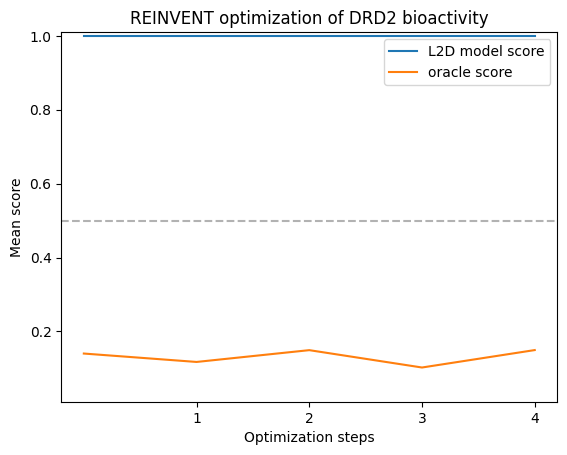

In [29]:
plt.plot(np.arange(n_rounds), mean_pred_score_by_round)
plt.plot(np.arange(n_rounds), mean_oracle_score_by_round)
plt.title(r"REINVENT optimization of DRD2 bioactivity")
plt.axhline(y=0.5, color = "gray", linestyle = "--", alpha = 0.6)
plt.xlabel(r"Optimization steps")
plt.ylabel("Mean score")
plt.ylim((0.01, 1.01))
plt.xticks(np.arange(n_rounds))
plt.legend(["L2D model score", "oracle score"])

In [ ]:
n_rounds = 5
acquisition = "greedy"
directory_al = f"/home/klgx638/Projects/Reinvent_humanAI_reward/reinvent_runs/l2d-hitl-demo2_Tanimoto_K{n_rounds}_{acquisition}_T5_n10_seed1"
directory_base = f"/home/klgx638/Projects/Reinvent_humanAI_reward/reinvent_runs/l2d-hitl-demo2_Tanimoto_K{n_rounds}_None_seed1"

mean_pred_score_by_round_greedy = []
mean_oracle_score_by_round_greedy = []
deferrals_al = []

for k in range(n_rounds):
    model = NonLinearNetDefer(2048, 0.2)
    if k == 0:
        scaff = pd.read_csv(os.path.join(directory_base, "results/scaffold_memory.csv"))
        model.load_state_dict(torch.load("models/l2d_model_demo2.pt", map_location="cpu"))
    else:
        scaff = pd.read_csv(os.path.join(directory_al, f"iteration{k}_{acquisition}/results/scaffold_memory.csv"))
        if k == 1:
            model.load_state_dict(torch.load(os.path.join(directory_al, f"l2d_model_demo2_iteration_{k}.pt"), map_location="cpu"))
        else:
            model.load_state_dict(torch.load(os.path.join(directory_al, f"iteration{k-1}_{acquisition}/l2d_model_demo2_iteration_{k}.pt"), map_location="cpu"))
    scaff = scaff.sort_values(by=["raw_bioactivity"], ascending=False).head(100)
    fps = fingerprints_from_mol([Chem.MolFromSmiles(s) for s in scaff.SMILES.tolist()])
    preds, decision_outs = model(torch.tensor(fps, dtype=torch.float32))
    deferred = 0
    for i in range(len(fps)):
        if preds[i,1] > 0.5 and preds[i,1] > preds[i,0] and decision_outs[i,0] > preds[i,0] or preds[i,1] < 0.5 and preds[i,1] < preds[i,0] and decision_outs[i,0] > preds[i,0]:
            deferred += 1
    deferrals_al.append((deferred/len(fps))*100)
    mean_pred_score_by_round_greedy.append(np.mean(scaff.raw_bioactivity))
    mean_oracle_score_by_round_greedy.append(np.mean([oracle(s) for s in scaff.SMILES.tolist()]))

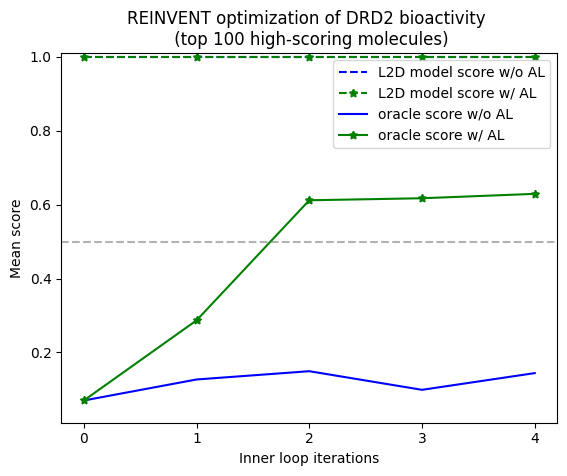

In [43]:
plt.plot(np.arange(n_rounds), mean_pred_score_by_round, color = "blue", linestyle = "--")
plt.plot(np.arange(n_rounds), mean_pred_score_by_round_greedy, color = "green", linestyle = "--", marker=(5, 1))
plt.plot(np.arange(n_rounds), mean_oracle_score_by_round, color = "blue")
plt.plot(np.arange(n_rounds), mean_oracle_score_by_round_greedy, marker=(5, 1), color = "green")
plt.title("REINVENT optimization of DRD2 bioactivity \n (top 100 high-scoring molecules)")
plt.axhline(y=0.5, color = "gray", linestyle = "--", alpha = 0.6)
plt.xlabel(r"Inner loop iterations")
plt.ylabel("Mean score")
plt.xticks(np.arange(n_rounds))
plt.ylim((0.01, 1.01))
plt.legend(["L2D model score w/o AL", "L2D model score w/ AL", "oracle score w/o AL", "oracle score w/ AL"])

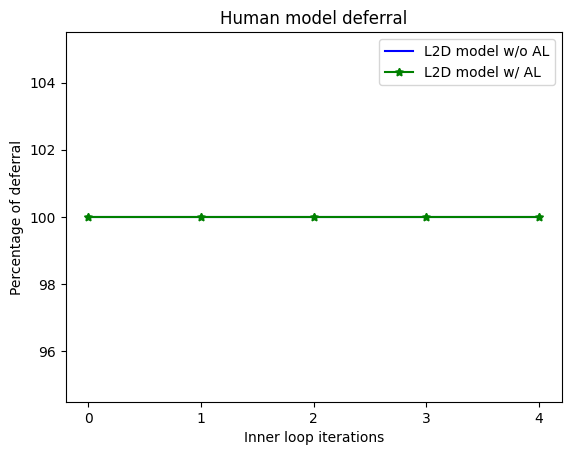

In [44]:
plt.plot(np.arange(n_rounds), deferrals, color="blue")
plt.plot(np.arange(n_rounds), deferrals_al, color="green", marker=(5, 1))
plt.title(r"Human model deferral")
plt.xlabel(r"Optimization steps")
plt.ylabel("Percentage of deferral")
plt.xlabel(r"Inner loop iterations")
plt.xticks(np.arange(n_rounds))
plt.legend(["L2D model w/o AL", "L2D model w/ AL"])

In [45]:
from scipy import stats
t_statistic, p_value = stats.ttest_ind(mean_oracle_score_by_round, mean_oracle_score_by_round_greedy)

alpha = 0.05  # significance level

if p_value < alpha:
    print("Significant difference")
else:
    print("No significant difference")

Reject the null hypothesis: There is a significant difference between the two groups.
